In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

In [2]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [4]:
benign_train = np.array(Dataset_loader('D:/Datasets/code ddsm 2(new)/benign_train',224))
malign_train = np.array(Dataset_loader('D:/Datasets/code ddsm 2(new)/malignant_train',224))
benign_test = np.array(Dataset_loader('D:/Datasets/code ddsm 2(new)/benign_test',224))
malign_test = np.array(Dataset_loader('D:/Datasets/code ddsm 2(new)/malignant_test',224))
benign_validation = np.array(Dataset_loader('D:/Datasets/code ddsm 2(new)/benign_validation',224))
malign_validation = np.array(Dataset_loader('D:/Datasets/code ddsm 2(new)/malignant_validation',224))

100%|██████████| 100/100 [00:15<00:00,  6.40it/s]


In [5]:
print('Resized Dimensions : ',benign_train.shape)
print('Resized Dimensions : ',benign_test.shape)
print('Resized Dimensions : ',malign_train.shape)
print('Resized Dimensions : ',malign_test.shape)
print('Resized Dimensions : ',malign_validation.shape)
print('Resized Dimensions : ',malign_validation.shape)

Resized Dimensions :  (300, 224, 224, 3)
Resized Dimensions :  (100, 224, 224, 3)
Resized Dimensions :  (300, 224, 224, 3)
Resized Dimensions :  (100, 224, 224, 3)
Resized Dimensions :  (100, 224, 224, 3)
Resized Dimensions :  (100, 224, 224, 3)


In [6]:
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
benign_validation_label = np.zeros(len(benign_validation))
malign_validation_label = np.ones(len(malign_validation))

In [7]:
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)
X_val = np.concatenate((benign_validation, malign_validation),axis=0)
Y_val = np.concatenate((benign_validation_label, malign_validation_label),axis=0)


In [8]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [9]:
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

In [10]:
s = np.arange(X_val.shape[0])
np.random.shuffle(s)
X_val = X_val[s]
Y_val = Y_val[s]

In [11]:
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)
Y_val = to_categorical(Y_val, num_classes= 2)

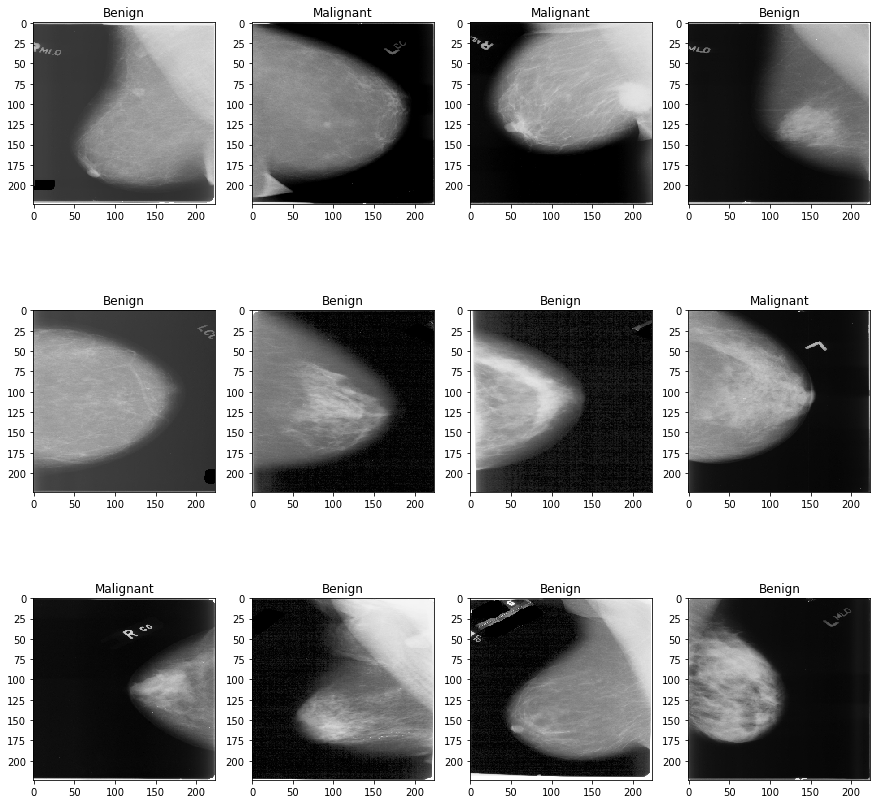

In [12]:
# # Display first 15 images , and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

In [13]:
def build_model(backbone, learning_rate=1e-5):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    
    return model

In [14]:
K.clear_session()
gc.collect()

resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,learning_rate = 1e-5)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1920)              0         
                                                                 
 batch_normalization (BatchN  (None, 1920)             7680      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dense_1 (Dense)             (None, 2)                 2

In [15]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=10,verbose=1,factor=0.2, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20,verbose=1, mode='max')

# Checkpoint
filepath="memo3.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [16]:
history = model.fit(
    X_train,Y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val,Y_val),
    callbacks=[learn_control, checkpoint ,early_stopping],
    shuffle=True
)

Epoch 1/100
19/19 [==============================] - ETA: 0s - loss: 0.7654 - accuracy: 0.4750 
Epoch 00001: val_accuracy improved from -inf to 0.54000, saving model to memo3.best.hdf5
19/19 [==============================] - 440s 22s/step - loss: 0.7654 - accuracy: 0.4750 - val_loss: 0.6915 - val_accuracy: 0.5400 - lr: 1.0000e-05
Epoch 2/100
19/19 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.6600 
Epoch 00002: val_accuracy improved from 0.54000 to 0.69500, saving model to memo3.best.hdf5
19/19 [==============================] - 403s 21s/step - loss: 0.6386 - accuracy: 0.6600 - val_loss: 0.6229 - val_accuracy: 0.6950 - lr: 1.0000e-05
Epoch 3/100
19/19 [==============================] - ETA: 0s - loss: 0.5657 - accuracy: 0.7317 
Epoch 00003: val_accuracy improved from 0.69500 to 0.84500, saving model to memo3.best.hdf5
19/19 [==============================] - 422s 22s/step - loss: 0.5657 - accuracy: 0.7317 - val_loss: 0.5559 - val_accuracy: 0.8450 - lr: 1.0000

In [17]:
model.load_weights("memo3.best.hdf5")

In [18]:
Y_val_pred = model.predict(X_val)

In [19]:
accuracy_score(np.argmax(Y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.96

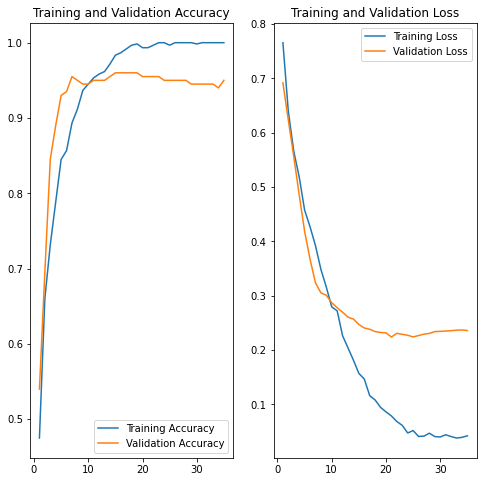

In [20]:
train_loss_fe = history.history['loss']
train_acc_fe = history.history['accuracy']
val_loss_fe = history.history['val_loss']
val_acc_fe = history.history['val_accuracy']

epochs_fe = range(1, len(train_acc_fe)+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_fe, train_acc_fe, label='Training Accuracy')
plt.plot(epochs_fe, val_acc_fe, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_fe,train_loss_fe , label='Training Loss')
plt.plot(epochs_fe, val_loss_fe, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
from time import sleep
import time
start = time.process_time() 
Y_pred = model.predict(X_test)
end = time.process_time()
print("Time per image: {} ".format((end-start)/len(X_test))) 

Time per image: 0.480859375 


Confusion matrix, without normalization
[[76 24]
 [12 88]]


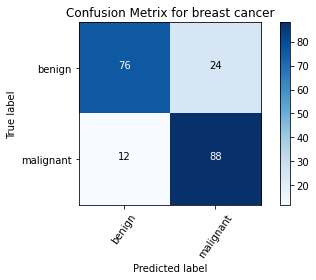

In [22]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for breast cancer')

In [23]:
from sklearn.metrics import classification_report
print(classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.76      0.81       100
           1       0.79      0.88      0.83       100

    accuracy                           0.82       200
   macro avg       0.82      0.82      0.82       200
weighted avg       0.82      0.82      0.82       200



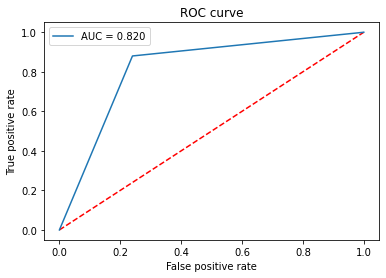

In [24]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.close()